# REPRESENTATION GROUP

## PROJECT INFORMATION

* **DATSET DESCRIPTION:**

The Autism Brain Imaging Data Exchange I (ABIDE I) represents the first ABIDE initiative. Started as a grass roots effort, ABIDE I involved 17 international sites, sharing previously collected resting state functional magnetic resonance imaging (Rs-fMRI), anatomical and phenotypic datasets made available for data sharing with the broader scientific community. This effort yielded 1112 dataset, including 539 from individuals with ASD and 573 from typical controls (ages 7-64 years, median 14.7 years across groups). This aggregate was released in August 2012. Its establishment demonstrated the feasibility of aggregating resting state fMRI and structural MRI data across sites; the rate of these data use and resulting publications (see Manuscripts) have shown its utility for capturing whole brain and regional properties of the brain connectome in Autism Spectrum Disorder (ASD). In accordance with HIPAA guidelines and 1000 Functional Connectomes Project / INDI protocols, all datasets have been anonymized, with no protected health information included. Below, are the specific types of information included in ABIDE I, the data usage agreement, sign up and data download links. http://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html

Firt development = 160 subjects NYU Center

* **BRAIN PARCELLATION:**

Craddock atlas, 200 Regions of Interest. It is a data-driven method for generating an ROI atlas by parcellating whole brain resting-state fMRI data into spatially coherent regions of homogeneous FC. Generated via spatially constrained spectral clustering (Fine-grained random parcellations informed by rs-fMRI data). This atlas were generated using a variety of parcellation strategies applied to a dataset of 41 healthy controls. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.21333

 * **RESEARCH QUESTION**

 Can deep learning models accurately classify individuals with autism spectrum disorder (ASD) and neurotypical individuals based on fMRI data, and what are the potential biases in the model's performance, particularly with respect to sex (e.g., classifying autistic females)?

 * **HYPOTHESIS**

 Deep learning models can exhibit biases in their classification of individuals with autism spectrum disorder (ASD) and neurotypical individuals, influenced by the subject's sex. These biases may arise from either intrinsic significant brain activity differences or biases in diagnosis parameters.

In [1]:
# davos is nice for managing notebook dependencies-- just change "import" to
# "smuggle" after this cell and libraries will install automatically as needed
%pip install davos
import davos
davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [56]:
# Python libs
from pathlib smuggle Path
smuggle math
smuggle os

# Scientific computation and data analysis
smuggle numpy as np
smuggle pandas as pd
from scipy.io smuggle loadmat
smuggle random

# Neuroimaging libraries
smuggle nilearn
smuggle nibabel as nib
from nilearn smuggle datasets

# Plot libraries
smuggle matplotlib.pyplot as plt
from matplotlib.colors smuggle ListedColormap
from heatmap smuggle heatmap, corrplot   # pip: heatmapz
from nilearn smuggle plotting
from nilearn.connectome smuggle ConnectivityMeasure
smuggle seaborn as sns
sns.set(font_scale=1.4) # for label size

# Misc
smuggle pickle  # To save/load Python objects to disk
# from google.colab smuggle drive  # To access Google Drive data
from tqdm.auto import tqdm
from IPython.display import display
import warnings

# DL
smuggle torch
from torch.utils.data smuggle DataLoader, TensorDataset
from sklearn.model_selection smuggle train_test_split
import torch.nn as nn
import torch.optim as optim

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
# import random
# import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [5]:
# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [6]:
device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [7]:
# # Mount the Google Drive to access data
# # Needs to log in in a separate window
# gdrive = "/content/drive"
# drive.mount(gdrive)
# nma_drive = Path("/content/drive/Shareddrives/Neuromatch-Eotyrannus_Stick")
nma_drive = Path(".")
abide_path = Path(nma_drive / "ABIDE_pcp")

if not abide_path.exists():
  raise FileNotFoundError('Running this notebook requires access to the shared Google Drive folder')

In [8]:
# Load the already saved CSV file from the drive
Phenotypic_V1_0b_path = Path(abide_path / "Phenotypic_V1_0b_preprocessed1.csv")
Phenotypic_V1_0b_dat = pd.read_csv(Phenotypic_V1_0b_path)
Phenotypic_V1_0b_dat

,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1107,1108,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,...,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1108,1108,1109,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,...,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN,0
1109,1109,1110,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,...,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1110,1110,1111,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0


In [9]:
# Get all the subject IDs from NYU
subject_list = Phenotypic_V1_0b_dat[Phenotypic_V1_0b_dat.SITE_ID == "NYU"].SUB_ID
subject_list

643    50952
644    50953
645    50954
646    50955
647    50956
       ...  
833    51153
834    51154
835    51155
836    51156
837    51159
Name: SUB_ID, Length: 184, dtype: int64

In [10]:
# Download the dataset
if not nma_drive.joinpath('abide_pcp_whole.pkl').exists():
    abide = datasets.fetch_abide_pcp(data_dir=nma_drive, pipeline = "cpac", derivatives = ["func_preproc", "rois_cc200"], quality_checked = True, legacy_format = False)#, SUB_ID = list(subject_list))
    
    # # Then save the dataset to the drive as a Pickle file
    # # Only need to do it once
    with open(nma_drive / "abide_pcp_whole.pkl", "wb") as fid:
      pickle.dump(abide, fid)

In [11]:
# Load the dataset from the drive
with open(nma_drive / "abide_pcp_whole.pkl", "rb") as f:
    abide = pickle.load(f)
# abide

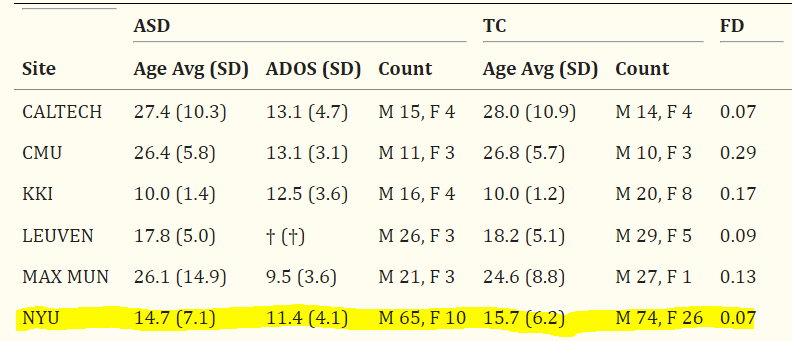

Until now, we have 160 subjects, with functional images in .nii format and parcelled with Craddock atlas, 200 ROIS

In [12]:
print(abide.keys())

dict_keys(['description', 'phenotypic', 'func_preproc', 'rois_cc200'])


In [13]:
len(abide.rois_cc200)

871

In [14]:
phen_abide = abide['phenotypic']
phen_abide

,i,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1107,1108,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,...,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1108,1108,1109,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,...,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN,0
1109,1109,1110,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,...,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1110,1110,1111,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0


In [15]:
inf_descrip = phen_abide[['AGE_AT_SCAN', 'SEX', 'DX_GROUP']]

inf_descrip.describe()

# females = inf_descrip.loc[inf_descrip['SEX'] == 2]

,AGE_AT_SCAN,SEX,DX_GROUP
count,871.000000,871.000000,871.000000
mean,16.943665,1.165327,1.537313
std,7.580910,0.371689,0.498892
min,6.470000,1.000000,1.000000
25%,11.920000,1.000000,1.000000
50%,14.750000,1.000000,2.000000
75%,19.779550,1.000000,2.000000
max,58.000000,2.000000,2.000000


In [16]:
males_stat = inf_descrip.loc[inf_descrip['SEX'] == 1]
males_stat.describe()

,AGE_AT_SCAN,SEX,DX_GROUP
count,727.000000,727.0,727.000000
mean,17.267801,1.0,1.519945
std,7.757163,0.0,0.499946
min,6.470000,1.0,1.000000
25%,12.005000,1.0,1.000000
50%,15.040000,1.0,2.000000
75%,20.190350,1.0,2.000000
max,58.000000,1.0,2.000000


In [17]:
females_stat = inf_descrip.loc[inf_descrip['SEX'] == 2]
females_stat.describe()

,AGE_AT_SCAN,SEX,DX_GROUP
count,144.000000,144.0,144.000000
mean,15.307224,2.0,1.625000
std,6.396594,0.0,0.485813
min,7.750200,2.0,1.000000
25%,11.170000,2.0,1.000000
50%,13.870000,2.0,2.000000
75%,17.200000,2.0,2.000000
max,45.000000,2.0,2.000000


In [18]:
NYU_dx_counts = phen_abide['DX_GROUP'].value_counts()
NYU_dx_counts # 86 Neurotypical Controls, 74 ASD

DX_GROUP
2    468
1    403
Name: count, dtype: int64

<BarContainer object of 2 artists>

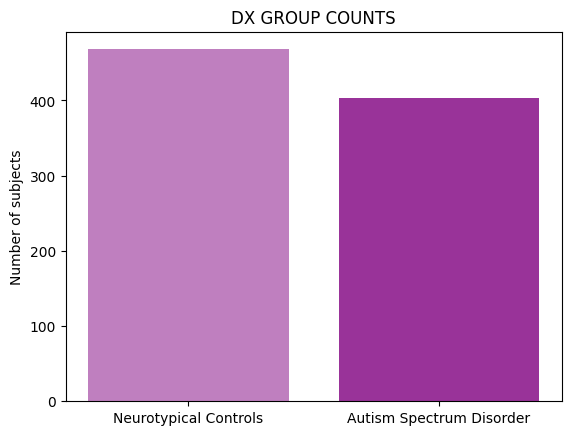

In [19]:
Y = NYU_dx_counts.values
X = ['Neurotypical Controls', 'Autism Spectrum Disorder']
plt.title('DX GROUP COUNTS')
plt.ylabel('Number of subjects')
color1 = (128/255, 0, 128/255, 0.5)
color2 = (128/255, 0, 128/255, 0.8)
plt.bar(X, Y, color = [color1, color2])

In [20]:
NYU_sex_counts = phen_abide['SEX'].value_counts()
NYU_sex_counts # Male 124, Female 36

SEX
1    727
2    144
Name: count, dtype: int64

<BarContainer object of 2 artists>

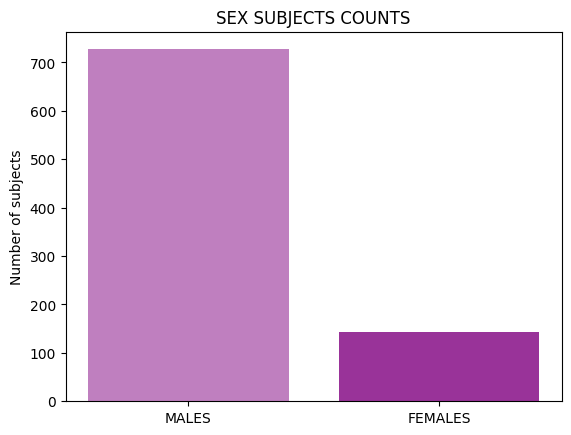

In [21]:
Y = NYU_sex_counts.values
X = ['MALES', 'FEMALES']
plt.title('SEX SUBJECTS COUNTS')
plt.ylabel('Number of subjects')
color1 = (128/255, 0, 128/255, 0.5)
color2 = (128/255, 0, 128/255, 0.8)
plt.bar(X, Y, color = [color1, color2])

In [22]:
NYU_ASD_MALE = phen_abide.loc[(phen_abide['DX_GROUP'] == 1) & (phen_abide['SEX'] == 1)]
NYU_ASD_MALE['DX_GROUP'].count() # 64 MALES WITH ASD, 60 MALES NEUROTYPICAL CONTROLS

349

In [23]:
NYU_ASD_FMALE = phen_abide.loc[(phen_abide['DX_GROUP'] == 1) & (phen_abide['SEX'] == 2)]
NYU_ASD_FMALE['DX_GROUP'].count() # 10 FEMALES WITH ASD, 26 FEMALES NEUROTYPICAL CONTROLS

54

<BarContainer object of 4 artists>

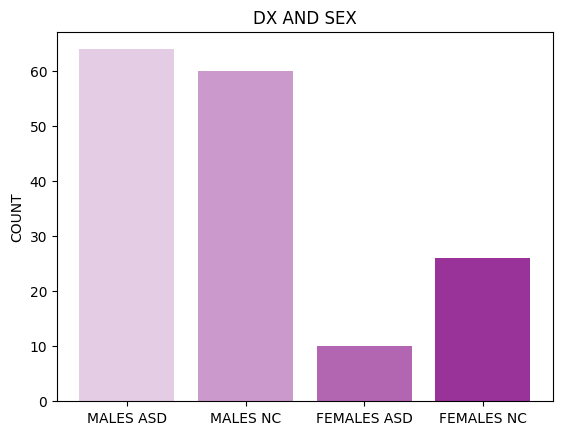

In [24]:
Y = [64, 60, 10, 26]
X = ['MALES ASD', 'MALES NC', 'FEMALES ASD', 'FEMALES NC']
color1 = (128/255, 0, 128/255, 0.2)
color2 = (128/255, 0, 128/255, 0.4)
color3 = (128/255, 0, 128/255, 0.6)
color4 = (128/255, 0, 128/255, 0.8)
plt.title('DX AND SEX')
plt.ylabel('COUNT')
plt.bar(X, Y, color = [color1, color2, color3, color4])

In [25]:
abide['rois_cc200'][0].shape #[Time series, ROIS] fmri --> pixels, voxels (3D) basic unit

(196, 200)

In [26]:
# x_data = np.asarray(abide['rois_cc200'])
# x_data.shape # 160 subjects, 176 time series, 200 ROIs

In [27]:
a_dims = np.array([item.shape for item in abide['rois_cc200']])
rois_dim = np.max(a_dims[:, 1])
ts_dim = np.max(a_dims[:, 0])
a_dims.shape, rois_dim, ts_dim

((871, 2), 200, 316)

In [28]:
x_data = np.zeros((ts_dim, rois_dim, len(abide['rois_cc200'])))
for idx, val in enumerate(abide['rois_cc200']):
    x_data[0:val.shape[0], 0:val.shape[1], idx] = val
x_data.shape

(316, 200, 871)

In [29]:
NYU_dx_counts = phen_abide['DX_GROUP']
y_target = np.array(NYU_dx_counts)
print(y_target, len(y_target), type(y_target))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 2
 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 1 1 1 

In [30]:
def replace_values(input_list):
    output_list = [0 if x == 1 else 1 if x == 2 else x for x in input_list]
    return np.array(output_list)

In [31]:
y_target = replace_values(y_target)
print(y_target, len(y_target))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 

In [32]:
abide['func_preproc'][0]

'./ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz'

In [33]:
test_subj_0 = nib.load(abide['func_preproc'][0])
print(test_subj_0.shape,'\n', test_subj_0.header, '\n', test_subj_0.header.get_xyzt_units())

(61, 73, 61, 196) 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  61  73  61 196   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.   3.   3.   3.   1.5  0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x     

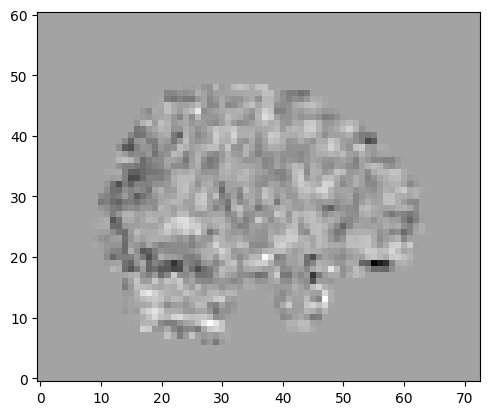

In [34]:
mid_slice_fmri = test_subj_0.get_fdata()[40, :, :, 0] # Slice 40, first volume
plt.imshow(mid_slice_fmri.T, cmap='gray', origin='lower') # 4D file

In [35]:
cc200 = datasets.fetch_atlas_craddock_2012(data_dir=None, url=None, resume=True, verbose=1, homogeneity=None, grp_mean=True)

/oscar/home/apierre3/Neuromatch-Eotyrannus_Stick/venv/lib/python3.11/site-packages/nilearn/datasets/atlas.py:269: FutureWarning: The default behavior of the function will be deprecated and replaced in release 0.13 to use the new parameters homogeneity and grp_mean.
  warnings.warn(


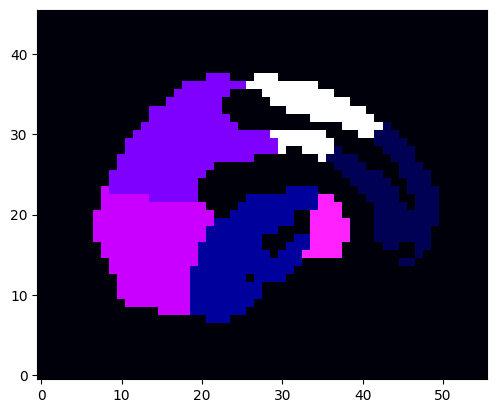

In [36]:
par_clusters = nib.load(cc200.random)
mid_slice_fmri = par_clusters.get_fdata()[20, :, :, 0] # Slice 20, first volume
plt.imshow(mid_slice_fmri.T, cmap='black_purple', origin='lower')

In [37]:
half_dim = int(rois_dim * rois_dim/2 - rois_dim/2)
half_dim

19900

In [38]:
corrpearson_subjects_path = nma_drive.joinpath("corrpearson_half_subjects.npy")
if not corrpearson_subjects_path.exists():
    pearson_corr = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True) # Pearson
    # covariance = ConnectivityMeasure(kind='covariance')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Temporarily ignore FutureWarning
        # Computing Functional Connectivity
        # corrpearson_subjects = [pearson_corr.fit_transform(abide['rois_cc200'])[i] for i in tqdm(range(len(abide['rois_cc200'])))] # X _ features #
        corrpearson_subjects = np.zeros((len(abide['rois_cc200']), half_dim,))
        for idx, val in enumerate(tqdm(abide['rois_cc200'])):
            corrpearson_subjects[idx, :] = pearson_corr.fit_transform(abide['rois_cc200'])[idx]
        
    # corrmat = pearson_corr.fit_transform(abide['rois_cc200'])[0]
    # corr_pearson_seitzman = [correlation_Pearson.fit_transform([subjects_seitzman[i]])[0] for i in range(len(subjects_seitzman))]
    np.save(corrpearson_subjects_path, corrpearson_subjects, allow_pickle=True, fix_imports=True)
else:
    corrpearson_subjects = np.load(corrpearson_subjects_path)

In [39]:
np.asarray(corrpearson_subjects).shape

(871, 19900)

In [40]:
corrpearson_subjects = torch.tensor(corrpearson_subjects)

# Autoencoder

In [41]:
# import torch
# import torch.nn as nn

X = corrpearson_subjects.float()
# X = corrpearson_subjects.float().reshape(corrpearson_subjects.shape[0], -1)
X.shape

torch.Size([871, 19900])

In [42]:
# Definir la clase del primer autoencoder
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(19900, 10000),
            nn.Tanh(),#nn.ReLU()
            nn.Linear(10000, 5000),
            nn.Tanh(),
            nn.Linear(5000, 1000),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1000, 5000),
            nn.Tanh(), #nn.ReLU()
            nn.Linear(5000, 10000),
            nn.Tanh(),
            nn.Linear(10000, 19900),
            nn.Tanh()
        )
        self.corruption = nn.Dropout(p=0.2)

    def forward(self, x):
        #x_corrupted = torch.bernoulli(x, p=0.2) * x
        #x = self.encoder(x_corrupted)
        x = self.corruption(x) ## esta borrar
        x = self.encoder(x) ## esta borrar
        x = self.decoder(x)
        return x

# Crear una instancia del primer autoencoder
autoencoder1 = Autoencoder1().float()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder1.parameters(), lr=0.0001) # 0.001

# Entrenamiento
# num_epochs = 200
num_epochs = 70
for epoch in range(num_epochs):
    # Forward pass
    outputs = autoencoder1(X)

    # Calcular la pérdida
    loss = criterion(outputs, X)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Imprimir información del entrenamiento
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Obtener la representación reducida de los datos
encoded_data = autoencoder1.encoder(X)

Epoch [1/70], Loss: 0.0863
Epoch [2/70], Loss: 0.0874
Epoch [3/70], Loss: 0.0445
Epoch [4/70], Loss: 0.0349
Epoch [5/70], Loss: 0.0435
Epoch [6/70], Loss: 0.0275
Epoch [7/70], Loss: 0.0377
Epoch [8/70], Loss: 0.0264
Epoch [9/70], Loss: 0.0311
Epoch [10/70], Loss: 0.0263
Epoch [11/70], Loss: 0.0267
Epoch [12/70], Loss: 0.0256
Epoch [13/70], Loss: 0.0240
Epoch [14/70], Loss: 0.0244
Epoch [15/70], Loss: 0.0233
Epoch [16/70], Loss: 0.0236
Epoch [17/70], Loss: 0.0230
Epoch [18/70], Loss: 0.0219
Epoch [19/70], Loss: 0.0221
Epoch [20/70], Loss: 0.0207
Epoch [21/70], Loss: 0.0213
Epoch [22/70], Loss: 0.0203
Epoch [23/70], Loss: 0.0210
Epoch [24/70], Loss: 0.0196
Epoch [25/70], Loss: 0.0200
Epoch [26/70], Loss: 0.0197
Epoch [27/70], Loss: 0.0190
Epoch [28/70], Loss: 0.0194
Epoch [29/70], Loss: 0.0195
Epoch [30/70], Loss: 0.0189
Epoch [31/70], Loss: 0.0186
Epoch [32/70], Loss: 0.0190
Epoch [33/70], Loss: 0.0192
Epoch [34/70], Loss: 0.0187
Epoch [35/70], Loss: 0.0184
Epoch [36/70], Loss: 0.0187
E

In [43]:
# Definir la clase del segundo autoencoder
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1000, 600),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(600, 1000),
            nn.Tanh()
        )
        self.corruption = nn.Dropout(p=0.3)

    def forward(self, x):
        #x_corrupted = x.clone()
        #x_corrupted.bernoulli_(p=0.3)  # Aplicar corrupción directamente al tensor sin crear uno nuevo
        #x = self.encoder(x_corrupted)
        x = self.corruption(x) ## esta borrar
        x = self.encoder(x) ## esta borrar
        x = self.decoder(x)
        return x

# Crear una instancia del segundo autoencoder
autoencoder2 = Autoencoder2().float()

# Definir la función de pérdida y el optimizador
criterion_2 = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder2.parameters(), lr=0.001) #0.001
# Entrenamiento
num_epochs = 200
autoencoder2.train()  # Cambiar el modo a entrenamiento
for epoch in range(num_epochs):
    # Forward pass
    outputs = autoencoder2(encoded_data)

    # Calcular la pérdida
    loss = criterion_2(outputs, encoded_data)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Agregar retain_graph=True
    optimizer.step()

    # Imprimir información del entrenamiento
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Obtener la representación reducida de los datos
encoded_data_2 = autoencoder2.encoder(encoded_data)  # Usar la salida del primer autoencoder como entrada para el segundo

# Imprimir información de la representación reducida
print(encoded_data_2)

Epoch [1/200], Loss: 0.1900
Epoch [2/200], Loss: 0.1095
Epoch [3/200], Loss: 0.0556
Epoch [4/200], Loss: 0.0325
Epoch [5/200], Loss: 0.0279
Epoch [6/200], Loss: 0.0262
Epoch [7/200], Loss: 0.0236
Epoch [8/200], Loss: 0.0203
Epoch [9/200], Loss: 0.0181
Epoch [10/200], Loss: 0.0172
Epoch [11/200], Loss: 0.0164
Epoch [12/200], Loss: 0.0151
Epoch [13/200], Loss: 0.0136
Epoch [14/200], Loss: 0.0124
Epoch [15/200], Loss: 0.0114
Epoch [16/200], Loss: 0.0109
Epoch [17/200], Loss: 0.0104
Epoch [18/200], Loss: 0.0099
Epoch [19/200], Loss: 0.0092
Epoch [20/200], Loss: 0.0085
Epoch [21/200], Loss: 0.0080
Epoch [22/200], Loss: 0.0076
Epoch [23/200], Loss: 0.0073
Epoch [24/200], Loss: 0.0069
Epoch [25/200], Loss: 0.0065
Epoch [26/200], Loss: 0.0061
Epoch [27/200], Loss: 0.0059
Epoch [28/200], Loss: 0.0057
Epoch [29/200], Loss: 0.0054
Epoch [30/200], Loss: 0.0052
Epoch [31/200], Loss: 0.0051
Epoch [32/200], Loss: 0.0049
Epoch [33/200], Loss: 0.0046
Epoch [34/200], Loss: 0.0045
Epoch [35/200], Loss: 0

In [44]:
encoded_data_2.shape

torch.Size([871, 600])

In [45]:
Y_tensor = torch.tensor(y_target)

DATA LOADER

In [46]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)

  X = X.detach().numpy()
  y = y.detach().numpy()
  #X = np.asarray(X)
  # Number of samples
  N = X.shape[0]
  print(N)
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Shuffle & split data")
  ####################################################################
  # Shuffle data
  shuffled_indices = torch.randperm(N)  # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float(), torch.from_numpy(X_train), torch.from_numpy(y_train)


In [47]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(encoded_data, Y_tensor, seed=SEED) # encoded_data_2

871


In [48]:
# Convertir X_train a una matriz de dos dimensiones (8, 200*200)
X_train = X_train.reshape(X_train.shape[0], -1)
print(X_train.shape)
# Convertir X_test a una matriz de dos dimensiones (2, 200*200)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_test.shape)

torch.Size([697, 1000])
torch.Size([174, 1000])


In [49]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

torch.Size([174, 1000]) torch.Size([174]) torch.Size([697, 1000]) torch.Size([697])


In [50]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 32
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)


train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

In [51]:
print(train_loader)
for batch_idx, (inputs, labels) in enumerate(train_loader):

    print('---- Training loaders ----')

    print(f"Batch {batch_idx}: Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

    # print(f"Batch {batch_idx}: Inputs:\n{inputs}")
    # print(f"Batch {batch_idx}: Labels:\n{labels}")

---- Training loaders ----
Batch 0: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 1: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 2: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 3: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 4: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 5: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 6: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 7: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 8: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])
---- Training loaders ----
Batch 9: Inputs shape: torch

In [52]:
for batch_idx, (inputs, labels) in enumerate(test_loader):

    print('\n')
    print('---- Testing loaders ----')

    print(f"Batch {batch_idx}: Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

    # print(f"Batch {batch_idx}: Inputs:\n{inputs}")
    # print(f"Batch {batch_idx}: Labels:\n{labels}")



---- Testing loaders ----
Batch 0: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])


---- Testing loaders ----
Batch 1: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])


---- Testing loaders ----
Batch 2: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])


---- Testing loaders ----
Batch 3: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])


---- Testing loaders ----
Batch 4: Inputs shape: torch.Size([32, 1000]), Labels shape: torch.Size([32])


---- Testing loaders ----
Batch 5: Inputs shape: torch.Size([14, 1000]), Labels shape: torch.Size([14])


In [53]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits


In [54]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      # print(outputs, type(outputs), outputs.shape)
      # print(labels.shape, type(labels), labels)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc, training_losses

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on the 672 training samples: 63.10
Accuracy on the 174 testing samples: 59.20


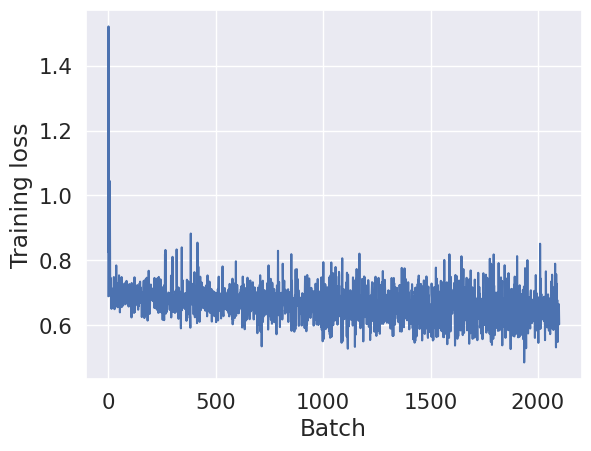

In [57]:
set_seed(SEED)
net = Net('Tanh()', X_train.shape[1], [1000,600], 2).to(device) #ReLU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005) # 1e-3
num_epochs = 100

_, _, training_losses = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)
